# ELEC4542 Introduction to deep learning for computer vision [Section 1A, 2023] Project

Name: Hong Yuk Sing

Topic: Image Classification


## Part2: Use different data augmentation techniques and different ways to avoid overfitting

The perforamce of model trained from task 1 is unsatifactory due to overfitting. In this section, data augmentation will be used to avoid over-fitting. Data augmentation creats variations of training data to increases its size at the same time regularizes the network. In this section, differnt combinations of data augmentation techniques (random flips and rotations, random crop and center crop, normalization and color jitter) will be tested and evaluated their performace.

The following combinations will be tested

*original (from task 1): normalization only

version 1. random flips and rotations, random crop and center crop, normalization and color jitter

version 2. random flips and rotations, random crop and center crop, and normalization

version 3. random crop and normalization, normalization and color jitter

In this model,torch and torchvision are used to load the dataset and network.

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import numpy as np

#### 2.1. Data Loader

The training dataset and the validation dataset are downloaded.

In [2]:
train_transform = transforms.Compose(
    [
    transforms.RandomHorizontalFlip(),                                      # random horizontal flip
    transforms.RandomRotation((-7,7)),                                      # random rotation
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),                  # random crop, center crop
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),   # color jitter
    transforms.ToTensor(),                                                  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                  #normalize
    ]
)

trainset = datasets.CIFAR10(root="data", train=True, download=True, transform=train_transform)

trainloader = DataLoader(
    trainset, batch_size=4, shuffle=True, num_workers=2)

test_transform = transforms.Compose(
    [
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
    ]
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=test_transform)

testloader = DataLoader(
    testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:08<00:00, 20778029.99it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


#### 2.2. Define the ResNet-18 model

In [3]:
# modify the last layer to have 10 output layers (which to map to the 10 classess of the dataset)
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = torch.nn.Linear(in_features=512, out_features=10)

if (torch.cuda.is_available()):
    device = "cuda"
elif (torch.backends.mps.is_available()) :
    device="mps"
else:
    device = "cpu"
print(device)
resnet18.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s] 


cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### 2.3. Loss and Optimizer

The model loss and optimizer will be defined as follows

In [4]:
# define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
# optimizer = optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.9)
# optimizer = optim.Adam(resnet18.parameters(), lr=0.01)
optimizer = torch.optim.AdamW(resnet18.parameters(), lr=1e-4, weight_decay=0.0001)

#
# Define a learning rate scheduler
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, verbose=True)
# scheduler = lr_scheduler.StepLR(optimizer, step_size = 5, gamma=0.1, verbose=True)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True, min_lr=1e-7, factor=0.5)


#### 2.4. Train the network

In [5]:
num_epochs = 40

# these lists will store the values for each epoch
train_losses = []
validation_losses = []

# Training
for epoch in range(num_epochs):
    train_losses_epoch=[]
    val_losses_epoch=[]
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        resnet18.train()
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet18(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # record the current batch loss
        loss = criterion(outputs, labels)
        train_losses_epoch.append(loss.item())

        loss.backward()
        optimizer.step()

        if i % 200 == 199:  # print every 200 mini-batches
            print(f'epoch {epoch}  batch {i+1}/{len(trainloader)}  running loss {np.mean(train_losses_epoch):.3f}')
            train_losses_epoch = []

    train_losses.append(np.mean(train_losses_epoch))  # record the mean loss for this epoch

    # get the test accuracy after each epoch
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = resnet18(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            val_loss = criterion(outputs, labels)
            val_losses_epoch.append(val_loss.item())
    
    validation_losses.append(np.mean(val_losses_epoch))  # record the mean validation loss for this epoch
    
    print('Accuracy of the network on the train images: %d %%' % (100 * correct / total))

    # step the scheduler
    scheduler.step(np.mean(train_losses_epoch))

epoch 0  batch 200/12500  running loss 2.341
epoch 0  batch 400/12500  running loss 2.107
epoch 0  batch 600/12500  running loss 2.088
epoch 0  batch 800/12500  running loss 2.055
epoch 0  batch 1000/12500  running loss 1.987
epoch 0  batch 1200/12500  running loss 1.892
epoch 0  batch 1400/12500  running loss 1.991
epoch 0  batch 1600/12500  running loss 1.950
epoch 0  batch 1800/12500  running loss 1.931
epoch 0  batch 2000/12500  running loss 1.861
epoch 0  batch 2200/12500  running loss 1.902
epoch 0  batch 2400/12500  running loss 1.832
epoch 0  batch 2600/12500  running loss 1.875
epoch 0  batch 2800/12500  running loss 1.926
epoch 0  batch 3000/12500  running loss 1.820
epoch 0  batch 3200/12500  running loss 1.853
epoch 0  batch 3400/12500  running loss 1.809
epoch 0  batch 3600/12500  running loss 1.858
epoch 0  batch 3800/12500  running loss 1.780
epoch 0  batch 4000/12500  running loss 1.752
epoch 0  batch 4200/12500  running loss 1.829
epoch 0  batch 4400/12500  running los

#### 2.5. Evaluate the model result using the testing dataset

Accuracy of the network on the train images: 87 %
Accuracy of the network on the test images: 83 %


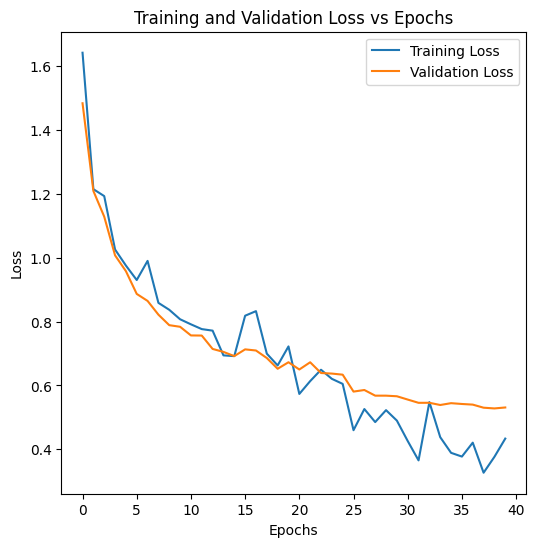

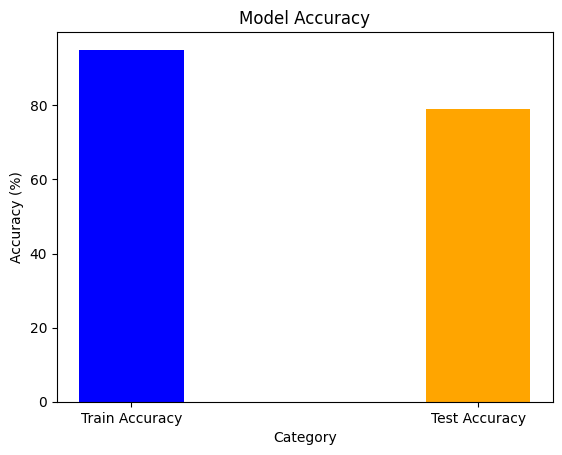

In [6]:
# Testing
correct = 0
total = 0

with torch.no_grad():
    for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

# plot training and validation loss
plt.figure(figsize=(6, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.legend()

plt.show()

# Data
categories = ['Train Accuracy', 'Test Accuracy']
values = [95, 79]

# Create bar chart
plt.bar(categories, values, color=['blue', 'orange'],width=0.3)

# Add title and labels
plt.title('Model Accuracy')
plt.xlabel('Category')
plt.ylabel('Accuracy (%)')

# Show the plot
plt.show()

here are some samples from the network


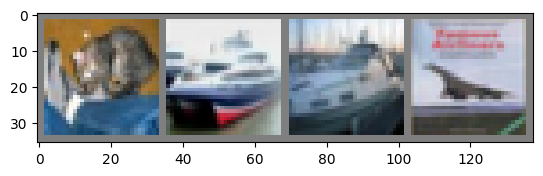

Predicted:    cat  ship   car plane
True:    cat  ship  ship plane


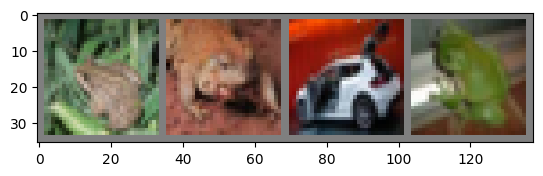

Predicted:   frog  frog   car  frog
True:   frog  frog   car  frog


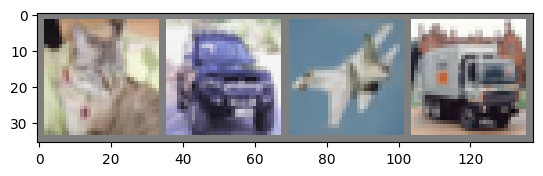

Predicted:    cat   car plane truck
True:    cat   car plane truck


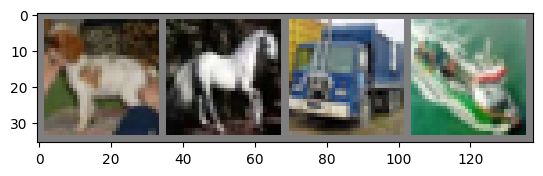

Predicted:    dog horse truck  ship
True:    dog horse truck  ship


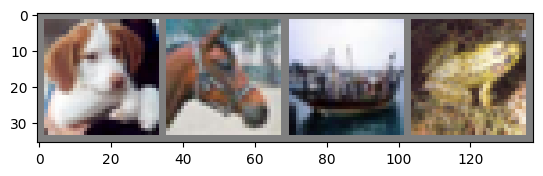

Predicted:    dog horse  ship  frog
True:    dog horse  ship  frog


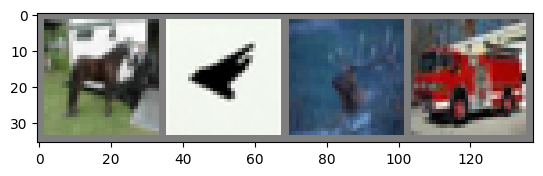

Predicted:  horse plane  deer truck
True:  horse plane  deer truck


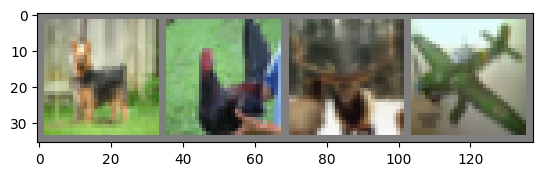

Predicted:   deer  bird  frog plane
True:    dog  bird  deer plane


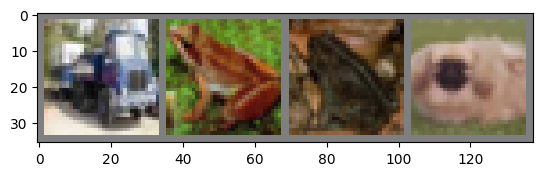

Predicted:  truck  frog  frog   dog
True:  truck  frog  frog   dog


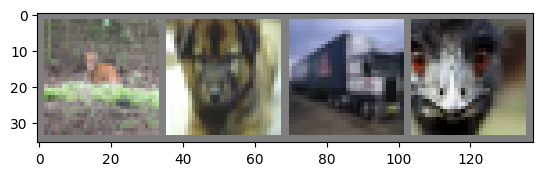

Predicted:   deer   dog truck   car
True:   deer   dog truck  bird


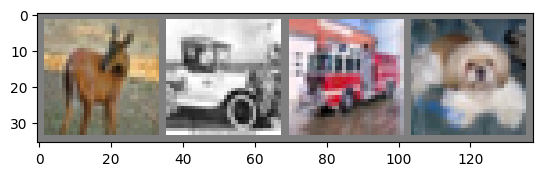

Predicted:   deer truck truck   dog
True:   deer   car truck   dog


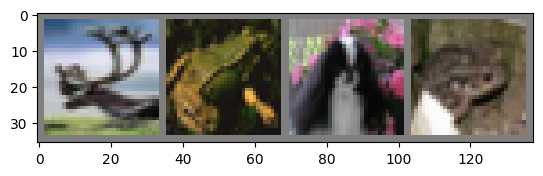

Predicted:   deer  frog   dog  frog
True:   deer  frog   dog  frog


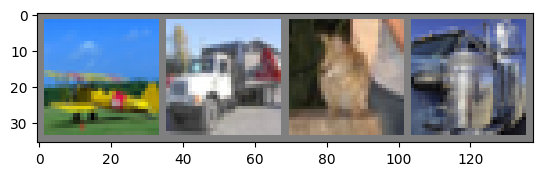

Predicted:  plane truck   cat truck
True:  plane truck   cat truck


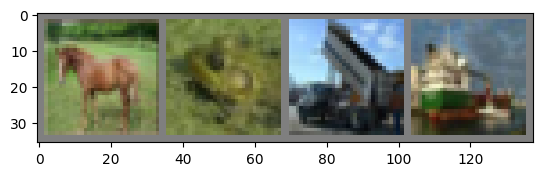

Predicted:  horse  frog truck  ship
True:  horse  frog truck  ship


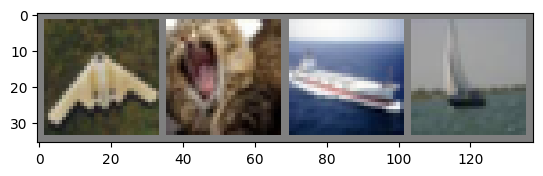

Predicted:   bird   dog  ship  ship
True:  plane   cat  ship  ship


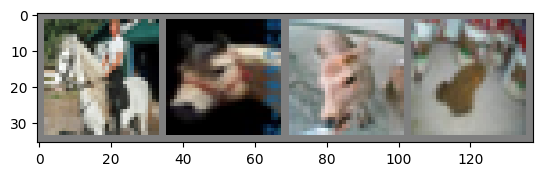

Predicted:  horse horse horse  bird
True:  horse horse  deer  frog


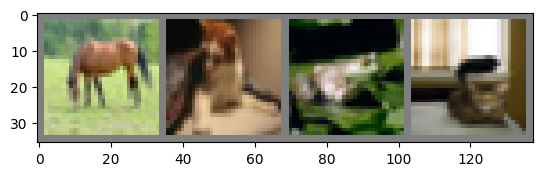

Predicted:  horse   dog  frog   cat
True:  horse   cat  frog   cat


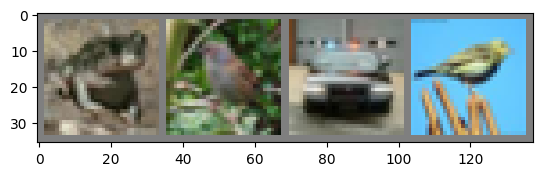

Predicted:   frog  bird   car  bird
True:   frog  bird   car  bird


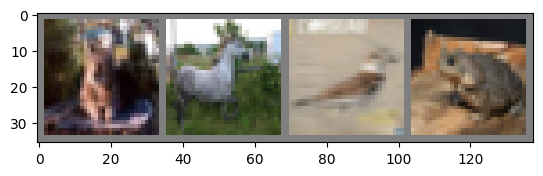

Predicted:   deer horse  bird  frog
True:    cat horse  bird  frog


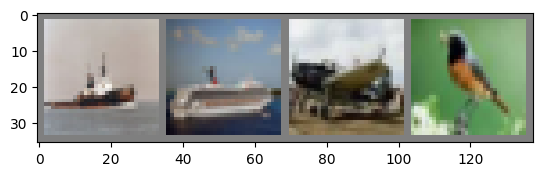

Predicted:   ship  ship plane  bird
True:   ship  ship plane  bird


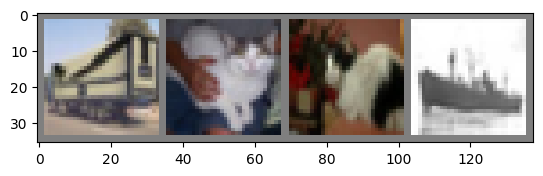

Predicted:  truck   cat   dog  ship
True:  truck   cat   cat  ship


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random test images
dataiter = iter(testloader)
num_of_images_to_be_printed = 20
counter = 0

print("here are some samples from the network")

for images, labels in testloader:
    if (counter == num_of_images_to_be_printed):
        break

    counter = counter + 1

    imshow(torchvision.utils.make_grid(images))
    outputs = resnet18(images.to(device))
    _, predicted = torch.max(outputs, 1)
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))
    print('True: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 2.6 Result and conclusion

#### Result

<table> <tr> <th> </th> <th>Original (40 epochs)</th> <th>Version 1</th> <th>Version 2</th> <th>Version 3</th> </tr> <tr> <td>Training data Accuracy</td> <td>99%</td> <td>81%</td> <td>82%</td> <td>88%</td> </tr> <tr> <td>Testing data Accuracy</td> <td>79%</td> <td>80%</td> <td>81%</td> <td>80%</td> </tr> </table>


Version 1 and 2 perform the best in term of the difference between training and test data accuracy, this showed that version 1  (with the use of random flips and rotations, random crop and center crop, normalization and color jitter) and 2 1  (with the use of random flips and rotations, random crop and center crop and normalization) can effective eliminating overfitting. 

Therefore, version 1 will be further trained with 40 epochs and result is 87% on training data and 83% on testing data set.


#### Conclusion

To eliminating overfitting, the combinate of using random flips and rotations, random crop and center crop, normalization and color jitter data augmentation performs the best. And will be adopt as the model for the next part.
